In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import polars as pl
import io
import itertools

from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

In [25]:
AA_hotspots = pl.read_csv(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/06.hotspots/hinch_2023_AA_hotspots.csv",
    null_values="NA",
).rename({
    "Chromosome": "chrom", 
    "Motif_Centre_Pos": "motif_center_pos",
    "Start_Pos": "hotspot_start_pos",
    "End_Pos": "hotspot_end_pos",    
})

In [24]:
CL4_hotspots = pl.read_csv(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/06.hotspots/hinch_2023_CL4_hotspots.csv",
    null_values="NA",
    separator=" ",
).rename({
    "Chromosome": "chrom", 
    "Motif_Centre_Pos": "motif_center_pos",
    "Start_Pos": "hotspot_start_pos",
    "End_Pos": "hotspot_end_pos",        
})

# Sample IDs

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]



In [6]:
basic_filtering = \
    (~pl.col("has_common_transition")) & \
    (pl.col("min_coverage_between_transitions_hap1") >= 3) & \
    (pl.col("min_coverage_between_transitions_hap2") >= 3) & \
    (pl.col("mapq1") >= 60) & \
    (pl.col("mapq2") >= 60) & \
    (pl.col("is_forward1") == pl.col("is_forward2"))

extra_filtering = \
    (pl.col("total_mismatches") <= 100) & \
    (pl.col("total_clipping") <= 10)

# Add cM

In [7]:
cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])


In [8]:
trusty_cls_df = (cls_df
    .filter(basic_filtering)
)

very_trusty_cls_df = trusty_cls_df.filter(extra_filtering)

In [9]:
cls_df

read_name,read_length,n_transitions,idx_transitions,snp_positions_on_read,class,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,min_coverage_between_transitions_hap1,min_coverage_between_transitions_hap2,mapq1,mapq2,is_forward1,is_forward2,has_common_transition,chrom,sample_id
str,i64,i64,list[i64],list[i64],str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,bool,bool,bool,str,str
"""m64094e_220917…",13778,1,[0],"[2605, 12200]","""ambiguous""",1,14,4,1,0,0,8,3,60,60,true,true,true,"""chr1_RagTag""","""PD50477f"""
"""m64094e_220917…",12333,1,[1],"[717, 3643, … 10941]","""CO""",1,13,8,9,0,0,4,4,60,60,false,false,true,"""chr1_RagTag""","""PD50477f"""
"""m64178e_220829…",11925,2,"[0, 1]","[5999, 9418, 9903]","""GC""",24,1,1,0,0,0,21,23,1,17,false,false,true,"""chr1_RagTag""","""PD50477f"""
"""m64094e_220917…",13967,2,"[0, 4]","[1038, 3584, … 12597]","""GC""",7,179,1,0,0,0,8,3,1,33,false,false,false,"""chr1_RagTag""","""PD50477f"""
"""m64094e_220917…",19959,3,"[2, 3, 4]","[3410, 3820, … 13460]","""CNCO""",95,21,11,22,12,1,5,18,0,1,false,false,true,"""chr1_RagTag""","""PD50477f"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""m64094e_220715…",4420,2,"[2, 3]","[718, 744, … 2285]","""GC""",43,54,6,9,2,1,4,7,60,7,true,true,true,"""chr22_RagTag""","""PD50489e"""
"""m64094e_220717…",11122,4,"[21, 22, … 39]","[551, 769, … 8490]","""CNCO""",0,0,0,0,2455,3,10,9,60,60,true,false,false,"""chr22_RagTag""","""PD50489e"""
"""m64174e_220620…",16067,4,"[10, 11, … 17]","[4041, 4068, … 15183]","""CNCO""",27,92,80,43,0,0,4,3,60,60,true,true,true,"""chr22_RagTag""","""PD50489e"""


In [10]:
def annotate_with_cM_bam_parquet(
    focal_sample_id, 
    chrom, 
    bam_filename, 
    parquet_filename, 
    rate_maps=None, 
    cls_df=None,
    AA_hotspots_df=None,
    CL4_hotspots_df=None,
):
    candidates_df = pl.read_parquet(parquet_filename)

    # try:
    rows = []
    for aln in pysam.AlignmentFile(bam_filename).fetch():
        rows.append([aln.query_name, aln.reference_start, aln.reference_end, aln.mapping_quality, aln.query_length])

    rows_df = pl.DataFrame(rows, schema=["read_name", "start_pos_0based", "end_pos_0based", "mapq", "read_length"])

    if rate_maps is not None:
        rate_map = rate_maps[chrom]
        start_poses_cm = rate_map.get_cumulative_mass(rows_df["start_pos_0based"]) * 1e2
        end_poses_cm = rate_map.get_cumulative_mass(rows_df["end_pos_0based"]) * 1e2
    else:    
        start_poses_cm = np.full(len(rows_df), np.nan)
        end_poses_cm = np.full(len(rows_df), np.nan) 

    # Apparently get_cumulative_mass results are in Morgan
    cM = (end_poses_cm - start_poses_cm)

    prob_CO = scipy.stats.poisson.sf(0, cM * 0.01)    

    rows_df = rows_df.with_columns(
        start_pos_cM = start_poses_cm,
        cM = cM,
        prob_CO = prob_CO,
        cM_per_bp_across_read = cM / pl.col("read_length"),
    )

    annotated_df = (candidates_df
        .join(rows_df, on="read_name", how="left")
        .with_columns(
            sample_id = pl.lit(focal_sample_id),
            chrom = pl.lit(chrom),            
        )
    )
    
    if cls_df is not None:
        # Add classification information
        annotated_df = annotated_df.join(
            cls_df.rename({"chrom": "chrom_denovo"}), 
            on=["read_name", "sample_id"], 
            how="left"
        )
        
        # Use that to narrow the cM range
        annotated_df = (annotated_df
            .with_columns(
                active_start_pos = pl.col("start_pos_0based") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
                active_end_pos = pl.col("start_pos_0based") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
            )
            .with_columns(
                active_region_length = pl.col("active_end_pos") - pl.col("active_start_pos"),                
            )
        )
        
        if rate_maps is not None:
            rate_map = rate_maps[chrom]
            active_start_poses_cm = rate_map.get_cumulative_mass(annotated_df["active_start_pos"]) * 1e2
            active_end_poses_cm = rate_map.get_cumulative_mass(annotated_df["active_end_pos"]) * 1e2
        else:    
            active_start_poses_cm = np.full(len(annotated_df), np.nan)
            active_end_poses_cm = np.full(len(annotated_df), np.nan) 

        active_cM = (active_end_poses_cm - active_start_poses_cm)
        
        annotated_df = (annotated_df
            .with_columns(
                active_start_pos_cM = active_start_poses_cm,
                active_end_pos_cM = active_end_poses_cm,
                active_cM = (active_end_poses_cm - active_start_poses_cm),
                cM_per_bp_across_active = (active_end_poses_cm - active_start_poses_cm) / pl.col("active_region_length"),
            )
        )
        
        if AA_hotspots_df is not None:
            AA_hotspots_df = (AA_hotspots_df
                .filter(pl.col("chrom") == chrom)
                .sort("
            )
            
    
    return annotated_df

def annotate_with_cM_grch37(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.aligned_to_grch37.bam"
    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        rate_maps = annotate.rate_maps,
        cls_df = cls_df,
    )

def annotate_with_cM_grch38(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.aligned_to_grch38.bam"
    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        rate_maps = None,
        cls_df = cls_df,
    )

def annotate_with_cM_T2T(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.aligned_to_T2T.bam"
    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename,
        rate_maps = None,
        cls_df = cls_df,
    )

def annotate_with_cM_random(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.random_reads.aligned_to_grch37.bam"
    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.all_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        rate_maps = annotate.rate_maps,
        cls_df = None,
    )

In [17]:
all_annotated_candidates_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_grch37)(focal_sample_id, chrom) 
               for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

# for focal_sample_id in sample_ids: 
#     for chrom in aut_chrom_names:
#         annotate_with_cM_grch37(focal_sample_id, chrom) 
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:   

In [18]:
all_annotated_candidates_T2T_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_T2T)(focal_sample_id, chrom) 
               for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

# for focal_sample_id in sample_ids: 
#     for chrom in aut_chrom_names:
#         annotate_with_cM_T2T(focal_sample_id, chrom) 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0998070240020752s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    2.4s finished


In [19]:
all_annotated_random_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_random)(focal_sample_id, chrom) 
                for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

all_annotated_random_df = all_annotated_random_df.drop_nulls()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:   

In [20]:
filtered_annotated_candidates_df_expanded = all_annotated_candidates_df.filter(basic_filtering & extra_filtering)
filtered_annotated_candidates_T2T_df_expanded = all_annotated_candidates_T2T_df.filter(basic_filtering & extra_filtering)

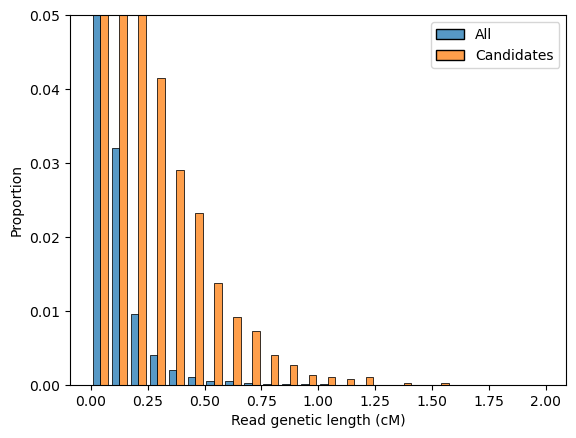

In [21]:
sns.histplot(
    [
        pd.Series(all_annotated_random_df["cM"], name="All"),
        pd.Series(filtered_annotated_candidates_df_expanded["cM"], name="Candidates"),
    ], 
    bins=np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

#plt.yscale("log");
plt.ylim(0,0.05);
plt.xlabel("Read genetic length (cM)");


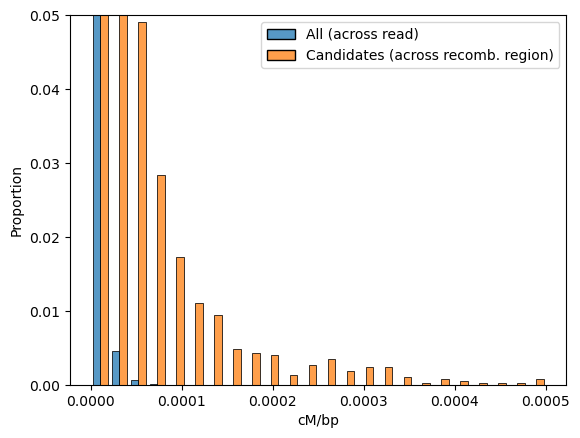

In [22]:
sns.histplot(
    [
        pd.Series(all_annotated_random_df["cM_per_bp_across_read"], name="All (across read)"),
        pd.Series(filtered_annotated_candidates_df_expanded["cM_per_bp_across_active"], name="Candidates (across recomb. region)"),
    ], 
    bins=np.linspace(0, 0.0005, 25), #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

#plt.yscale("log");
plt.ylim(0,0.05);
plt.xlabel("cM/bp");


/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


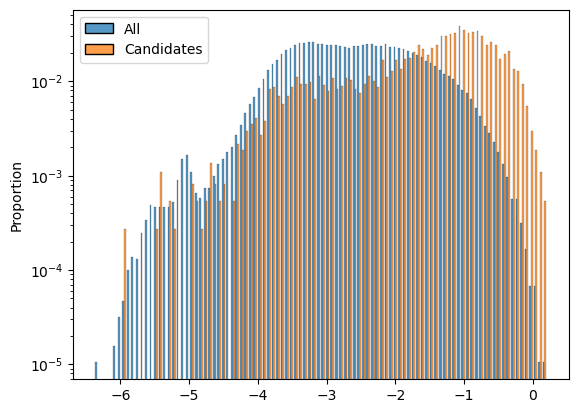

In [23]:
sns.histplot(
    [
        pd.Series(np.log10(all_annotated_random_df["cM"]), name="All"),
        pd.Series(np.log10(filtered_annotated_candidates_df_expanded["cM"]), name="Candidates"),
    ], 
#    bins=np.linspace(0, 2, 25),
    bins=100,
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

plt.yscale("log");

/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


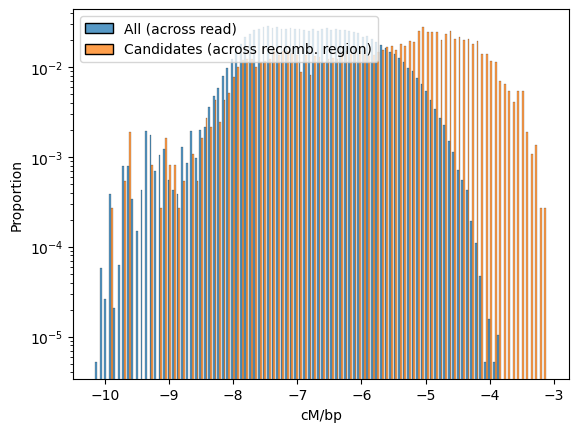

In [24]:
sns.histplot(
    [
        pd.Series(np.log10(all_annotated_random_df["cM_per_bp_across_read"]), name="All (across read)"),
        pd.Series(np.log10(filtered_annotated_candidates_df_expanded["cM_per_bp_across_active"]), name="Candidates (across recomb. region)"),
    ], 
    bins=100, 
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("cM/bp");


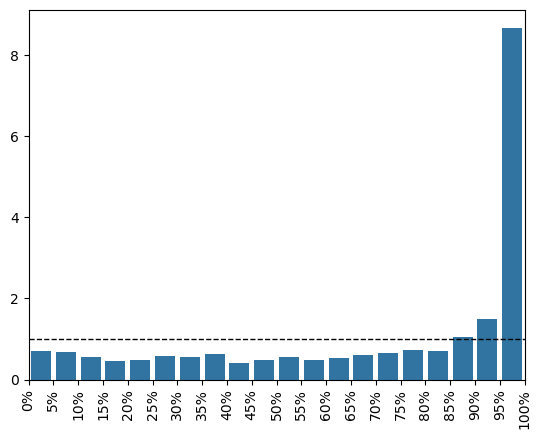

In [25]:
n_bins = 21



bins = np.linspace(0,1,n_bins)
qs = np.quantile(all_annotated_random_df["cM_per_bp_across_read"], q=bins)
y = np.histogram(filtered_annotated_candidates_df_expanded["cM_per_bp_across_active"], bins=qs)[0]
y = y / y.sum()
sns.barplot(
    x = bins[:-1],
    y = y/(1/n_bins), 
)
plt.axhline(1, lw=1, c="black", ls="--");


plt.xticks(ticks=np.arange(n_bins)-0.5, labels=[f"{int(x*100)}%" for x in bins], rotation=90);

<Axes: >

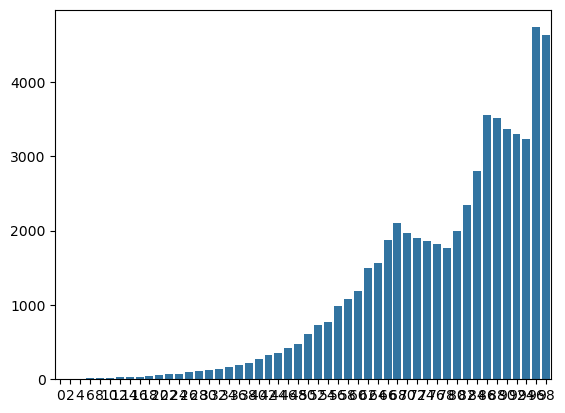

In [26]:
x = np.arange(0,100,2)

cm_thresholds = all_annotated_random_df["cM_per_bp_across_read"].mean() * x

ratios = [(filtered_annotated_candidates_df_expanded["cM_per_bp_across_active"]>T).mean() / (all_annotated_random_df["cM_per_bp_across_read"]>T).mean() for T in cm_thresholds]



sns.barplot(
    x=x, 
    y=ratios,
)


In [27]:
# plt.plot(trusty_cls_df["total_mismatches"].value_counts().sort("total_mismatches").head(50)["count"], '.')
# plt.plot(trusty_cls_df["total_common_insertions"].value_counts().sort("total_common_insertions").head(50)["count"], '.')
# plt.plot(trusty_cls_df["total_clipping"].value_counts().sort("total_clipping").head(50)["count"], '.')
# plt.yscale("log")

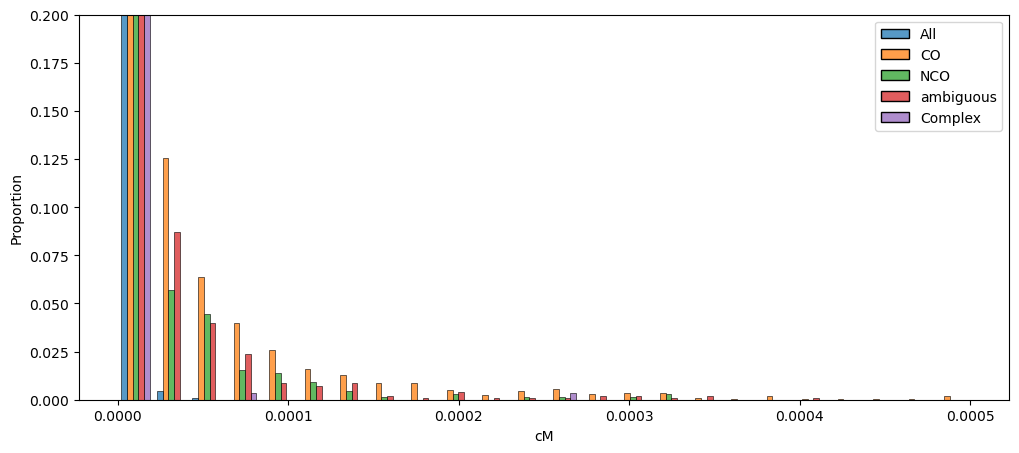

In [28]:
fig, ax = plt.subplots(figsize=(12,5))

sns.histplot(
    [
        pd.Series(all_annotated_random_df["cM_per_bp_across_read"], name="All"),
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CO")["cM_per_bp_across_active"], name="CO"),
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "GC")["cM_per_bp_across_active"], name="NCO"),
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "ambiguous")["cM_per_bp_across_active"], name="ambiguous"),
        pd.Series(filtered_annotated_candidates_df_expanded.filter(pl.col("class") == "CNCO")["cM_per_bp_across_active"], name="Complex"),
    ], 
    bins=np.linspace(0, 0.0005, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#ax.set_yscale("log");
ax.set_ylim(0, 0.2);
ax.set_xlabel("cM");

# What is the expected number of detected COs?

## Add high-quality SNP data for the random reads

In [29]:
def runme(focal_sample_id, chrom):
    snps_df = pl.read_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.snps.parquet"
    )

    frac_df = (snps_df
        .join(all_annotated_random_df, on="read_name")
        .filter(pl.col("is_high_quality_snp"))   # Not mid - because this is for detection
        .group_by("read_name")
        .agg(
            pl.col("length").len().alias("n_snps"),
            pl.col("start").first().alias("first_snp"),
            pl.col("start").last().alias("last_snp"),
            pl.col("read_length1").mean().alias("read_length"),
        )
        .select(
            "read_name",
            "n_snps",
            frac_detectable=(pl.col("last_snp") - pl.col("first_snp")) / pl.col("read_length"),
        )
    )

    return frac_df

frac_dfs = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(runme)(focal_sample_id, chrom)
        for focal_sample_id in sample_ids for chrom in aut_chrom_names
)

all_frac_df = pl.concat(frac_dfs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  9.1min
[Par

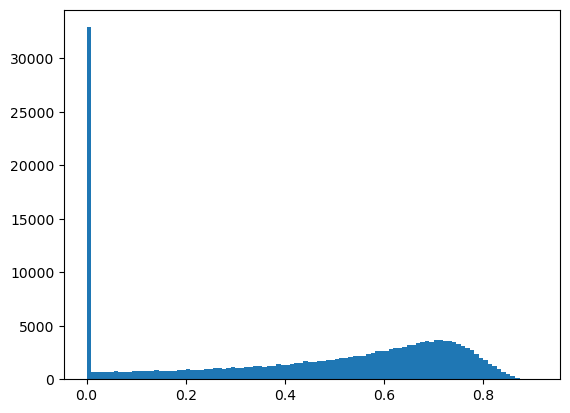

In [30]:
plt.hist(all_frac_df["frac_detectable"], bins=100);

In [31]:
(all_frac_df["frac_detectable"] == 0).mean()

0.16868284147050658

In [32]:
all_frac_df["frac_detectable"].mean()

0.44379094975544764

In [33]:
read_numbers = {}

ccs_read_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/02.ccs/")

for sample_id in sample_ids:
    count_path = ccs_read_path / sample_id / (sample_id + ".ccs.filtered.fastqc")
    d = open(count_path).read().strip().split()
    read_numbers[sample_id] = int(d[1])


In [34]:
rows = []

def runme(focal_sample_id, chrom):
    all_reads_df = pl.scan_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.high_confidence_snps.parquet"
    )

    n_reads = (all_reads_df
        .filter(
            (pl.col("mapq1") >= 60) & \
            (pl.col("mapq2") >= 60) & \
            (pl.col("is_forward1") == pl.col("is_forward2"))
        )
        .unique("read_name")
    ).select(pl.len()).collect(streaming=True).item()

    return [focal_sample_id, chrom, n_reads]

rows = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(runme)(focal_sample_id, chrom) for focal_sample_id in sample_ids for chrom in aut_chrom_names
)

filtered_read_counts_df = pl.DataFrame(rows, schema=["sample_id", "chrom", "n_reads"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:  1

In [35]:
filtered_read_numbers = dict(list(filtered_read_counts_df.group_by("sample_id").agg(pl.col("n_reads").sum()).iter_rows()))

In [36]:
expected_df = (all_annotated_random_df
    .join(all_frac_df, on="read_name")
    .select(
        "sample_id", 
        "chrom",
        prob_detected_CO = pl.col("frac_detectable") * pl.col("prob_CO")
    )
    .group_by("sample_id")
    .agg(pl.col("prob_detected_CO").mean())
    .join(
        pl.DataFrame([[sample_id, filtered_read_numbers[sample_id]] for sample_id in sample_ids], schema=["sample_id", "n_reads"]),
        on="sample_id",
    )
    .with_columns(
        expected_detected_CO = pl.col("n_reads") * pl.col("prob_detected_CO") 
    )
    .sort(by="sample_id")
)

In [37]:
observed_vs_expected_df = (very_trusty_cls_df
    #.filter((pl.col("total_mismatches") <= 100) & (pl.col("total_clipping") <= 10))
    #.filter((pl.col("total_mismatches") <= 5))
    .pivot(
        values=["class"],
        index=["sample_id"],
        columns=["class"],
        aggregate_function='len'
    )
    .join(expected_df, on="sample_id")
    .sort(by="sample_id") 
)

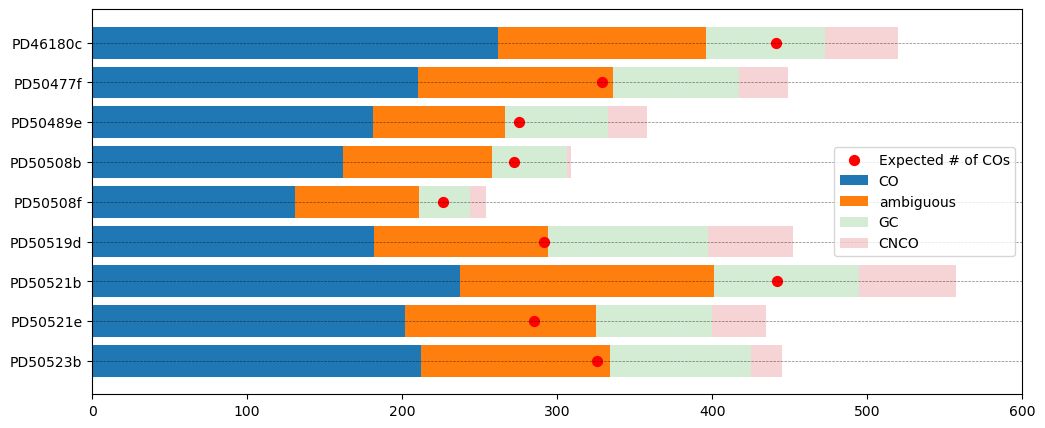

In [38]:
fig, ax = plt.subplots(figsize=(12, 5))
bottom = np.zeros(len(observed_vs_expected_df))

ax.barh(np.arange(len(observed_vs_expected_df)), left=bottom, width=observed_vs_expected_df["CO"], label="CO")

bottom += observed_vs_expected_df["CO"].to_numpy()
ax.barh(np.arange(len(observed_vs_expected_df)), left=bottom, width=observed_vs_expected_df["ambiguous"], label="ambiguous")

bottom += observed_vs_expected_df["ambiguous"].to_numpy()
ax.barh(np.arange(len(observed_vs_expected_df)), left=bottom, width=observed_vs_expected_df["GC"], label="GC", alpha=0.2)

bottom += observed_vs_expected_df["GC"].to_numpy()
ax.barh(np.arange(len(observed_vs_expected_df)), left=bottom, width=observed_vs_expected_df["CNCO"], label="CNCO", alpha=0.2)

for i in range(len(observed_vs_expected_df)):
    ax.axhline(i, lw=0.5, color="black", ls="--", alpha=0.5)
    ax.scatter(observed_vs_expected_df["expected_detected_CO"][i], i, color="red", s=50, label=("Expected # of COs" if i == 0 else None))

ax.legend()

ax.set_yticks(ticks=np.arange(len(observed_vs_expected_df)), labels=observed_vs_expected_df["sample_id"]);

ax.invert_yaxis()
ax.set_xlim(0,600);

In [39]:
with pl.Config(tbl_rows=-1, fmt_str_lengths=100):
    display(trusty_cls_df
        .filter(pl.col("sample_id") == "PD50521b")
        .filter(pl.col("chrom") == "chr1_RagTag")
        #.filter(pl.col("class") == "CO")
        .filter(pl.col("total_clipping") <= 10)
        .filter(pl.col("total_mismatches") >= 5)
        #.select(["read_name", "class", "total_mismatches"])
    )

read_name,read_length,n_transitions,idx_transitions,snp_positions_on_read,class,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,min_coverage_between_transitions_hap1,min_coverage_between_transitions_hap2,mapq1,mapq2,is_forward1,is_forward2,has_common_transition,chrom,sample_id
str,i64,i64,list[i64],list[i64],str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,bool,bool,bool,str,str
"""m64229e_220909_150132/124322302/ccs""",15993,1,[5],"[2122, 4881, … 15081]","""CO""",5,137,125,10,0,0,11,17,60,60,true,true,false,"""chr1_RagTag""","""PD50521b"""
"""m64229e_220909_150132/33360677/ccs""",13134,7,"[0, 1, … 10]","[2628, 2822, … 12317]","""CNCO""",20,24,7,18,0,0,14,6,60,60,true,true,false,"""chr1_RagTag""","""PD50521b"""
"""m64016e_220901_135237/21889074/ccs""",22793,1,[1],"[3408, 16030, … 22230]","""CO""",7,29,28,122,0,0,7,14,60,60,true,true,false,"""chr1_RagTag""","""PD50521b"""
"""m64016e_220901_135237/96471638/ccs""",16207,6,"[8, 9, … 13]","[2412, 2451, … 14675]","""CNCO""",21,28,24,25,0,0,18,20,60,60,true,true,false,"""chr1_RagTag""","""PD50521b"""
"""m64229e_220912_125215/17105077/ccs""",9015,1,[4],"[991, 1256, … 7006]","""CO""",122,16,16,11,0,0,16,14,60,60,true,true,false,"""chr1_RagTag""","""PD50521b"""
"""m64229e_220909_150132/171901326/ccs""",20072,1,[4],"[1052, 1731, … 17968]","""ambiguous""",5,77,70,32,0,0,10,13,60,60,true,true,false,"""chr1_RagTag""","""PD50521b"""
"""m64016e_220901_135237/26871710/ccs""",18063,1,[4],"[2676, 2935, … 17334]","""CO""",29,310,244,8,0,0,6,5,60,60,false,false,false,"""chr1_RagTag""","""PD50521b"""
"""m64229e_220912_125215/94110635/ccs""",27499,1,[10],"[2018, 2798, … 11940]","""ambiguous""",9,98,91,53,0,0,19,14,60,60,true,true,false,"""chr1_RagTag""","""PD50521b"""
"""m64229e_220912_125215/137233520/ccs""",20653,1,[6],"[923, 4196, … 19664]","""CO""",5,14,14,43,0,0,20,18,60,60,true,true,false,"""chr1_RagTag""","""PD50521b"""


# Crossovers per and along the chromosomes

## Per chromosome

In [40]:
c2n = {(x,y.replace("_RagTag", "")):z for x,y,z in (very_trusty_cls_df
    .group_by("class", "chrom")
    .len()
    .iter_rows()
)}


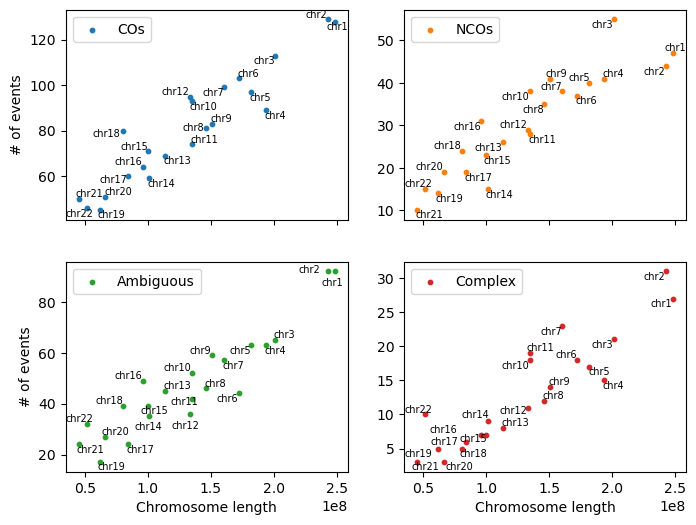

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(8,6), sharex=True)


for class_name, class_label, ax, color in [
    ["CO", "COs", axs[0,0], "C0"],
    ["GC", "NCOs", axs[0,1], "C1"],
    ["ambiguous", "Ambiguous", axs[1,0], "C2"],
    ["CNCO", "Complex", axs[1,1], "C3"],
]:
    xs = [liftover.T2T_chromosome_sizes_in_bp[chrom] for chrom in aut_chrom_names]
    ys = [c2n[class_name, chrom] for chrom in aut_chrom_names]
    
    ax.scatter(
        x = xs,
        y = ys,
        label = class_label,
        s = 10,
        c = color,
    )
    
    texts = [ax.text(xs[i], ys[i], aut_chrom_names[i], ha='center', va='center', fontdict={"size": 7}) for i in range(len(xs))]

    if class_name in ["ambiguous", "CNCO"]:
        ax.set_xlabel("Chromosome length");
    if class_name in ["CO", "ambiguous"]:
        ax.set_ylabel("# of events");
    ax.legend();
    adjust_text(texts, ax=ax)

## Where are they along the chromosome?

In [42]:
all_poses_df = (filtered_annotated_candidates_T2T_df_expanded
    .join(
        very_trusty_cls_df.select("read_name"), 
        on="read_name",
    )
    .select(
        "read_name",
        "sample_id",
        "chrom",
        "class",
        "start_pos_0based",
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)).alias("snp_before"),
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0) + 1).alias("snp_after"),
    )
    .with_columns(
        (pl.col("start_pos_0based") + (pl.col("snp_after") - pl.col("snp_before"))//2).alias("pos_average"),
    )
    .join(
        pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "chrom_length"]),
        on="chrom",
    )
)

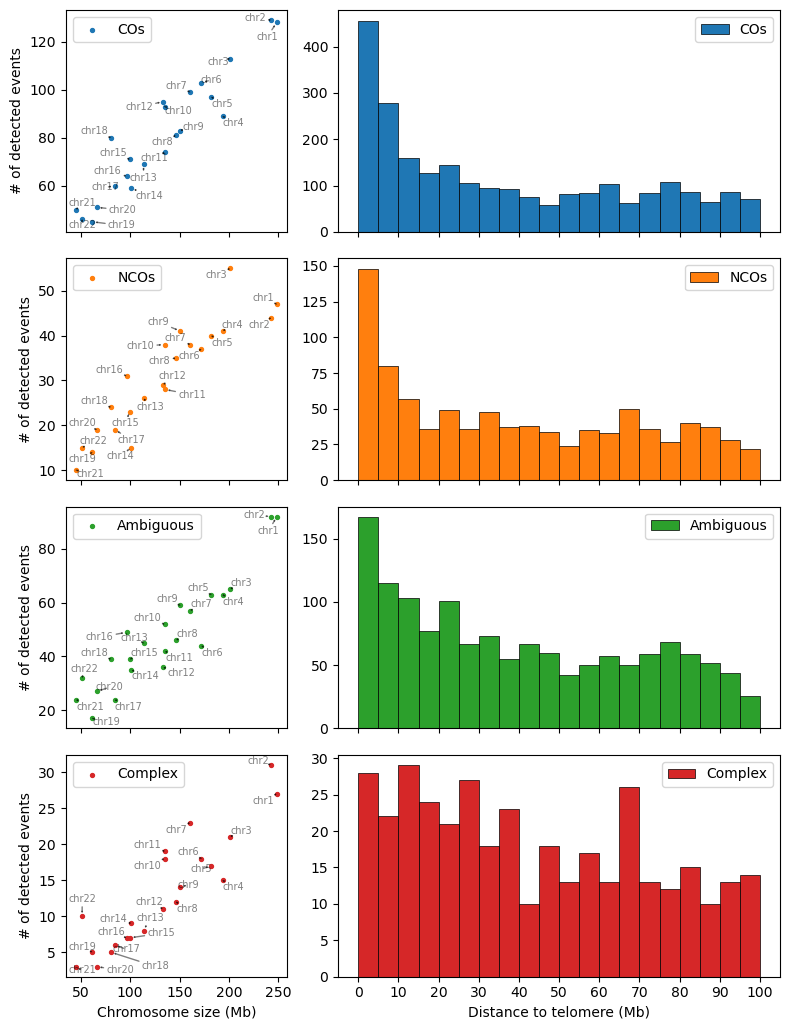

In [43]:
fig, axs = plt.subplots(4, 2, figsize=(10*0.8, 13*0.8), width_ratios=[1,2], sharex="col")

for row, class_name, class_label, color in [
    [0, "CO", "COs", "C0"],
    [1, "GC", "NCOs", "C1"],
    [2, "ambiguous", "Ambiguous", "C2"],
    [3, "CNCO", "Complex", "C3"],
]:

    # Chrom length vs. number of events
    ax = axs[row, 0]
    
    xs = [liftover.T2T_chromosome_sizes_in_bp[chrom] for chrom in aut_chrom_names]
    ys = [c2n[class_name, chrom] for chrom in aut_chrom_names]
    
    ax.scatter(
        x = xs,
        y = ys,
        label = class_label,
        s = 8,
        c = color,
    )
    
    texts = [ax.text(xs[i], ys[i], aut_chrom_names[i], ha='center', va='center', fontdict={"size": 7}, alpha=0.5) for i in range(len(xs))]

    ax.set_ylabel("# of detected events");
    ax.legend();
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', alpha=0.5), min_arrow_len=0, ax=ax)
    
    # Start of telomere
    ax = axs[row, 1]
    
    bins = np.arange(0, 1e8+5e6, 5e6)
    counts = np.histogram(
        pl.concat([
            all_poses_df.filter(pl.col("class") == class_name).select(pl.col("pos_average").alias("dist")),
            all_poses_df.filter(pl.col("class") == class_name).select((pl.col("chrom_length") - pl.col("pos_average")).alias("dist")),
        ]),
        bins = bins,
    )[0]

    xs = (bins[1:]+bins[:-1])/2
    ax.bar(
        x = xs,
        height = counts,
        width = (bins[1]-bins[0]), #*0.8,
#        s = 24,
        label = class_label,
        color = color,
        edgecolor = "black",
        linewidth = 0.5,
    );
    
    ax.legend()
    
axs[3,0].set_xticks(
    np.arange(0.5, 3, 0.5) * 1e8,
    labels = [f"{int(x*100)}" for x in np.arange(0.5, 3, 0.5)],
#    rotation=45,
)
axs[3,0].set_xlabel("Chromosome size (Mb)");

axs[3,1].set_xticks(
    np.arange(0, 1e8+1e7, 1e7),
    labels = [f"{int(x/1e6)}" for x in np.arange(0, 1e8+1e7, 1e7)],
#    rotation=45,    
)

axs[3,1].set_xlabel("Distance to telomere (Mb)");

plt.tight_layout()


## Do events follow the recombination map?

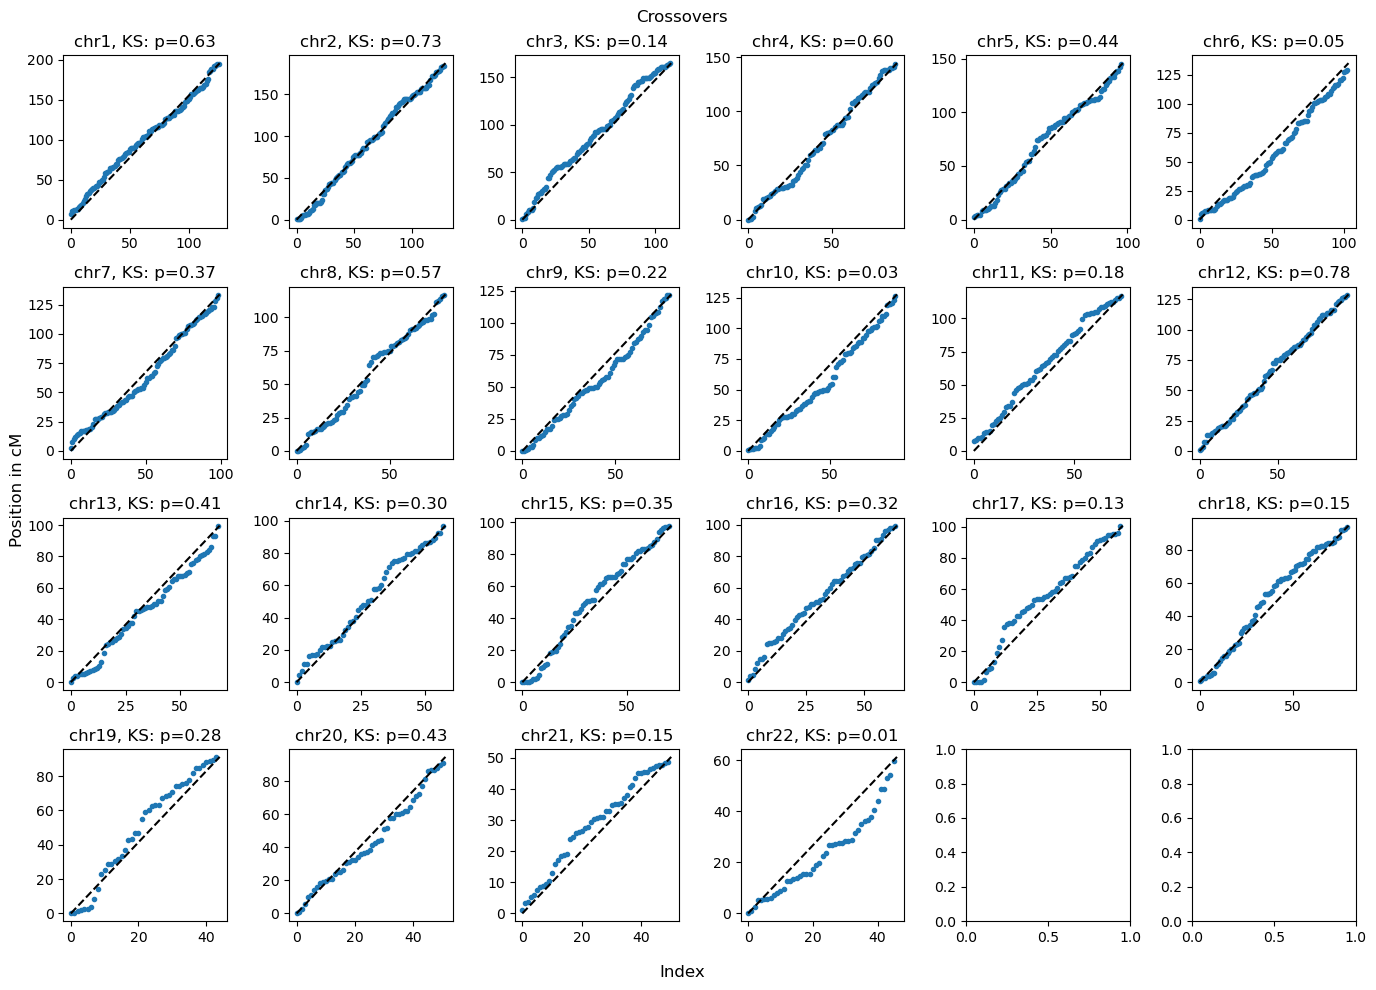

In [44]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    df = (filtered_annotated_candidates_df_expanded
        .filter((pl.col("class") == "CO") & (pl.col("chrom") == chrom))
        .sort("start_pos_cM")
        .drop_nulls()
    )

    midpoints_in_cms = np.sort(df["start_pos_cM"] + df["cM"]/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle("Crossovers");
    
plt.tight_layout()

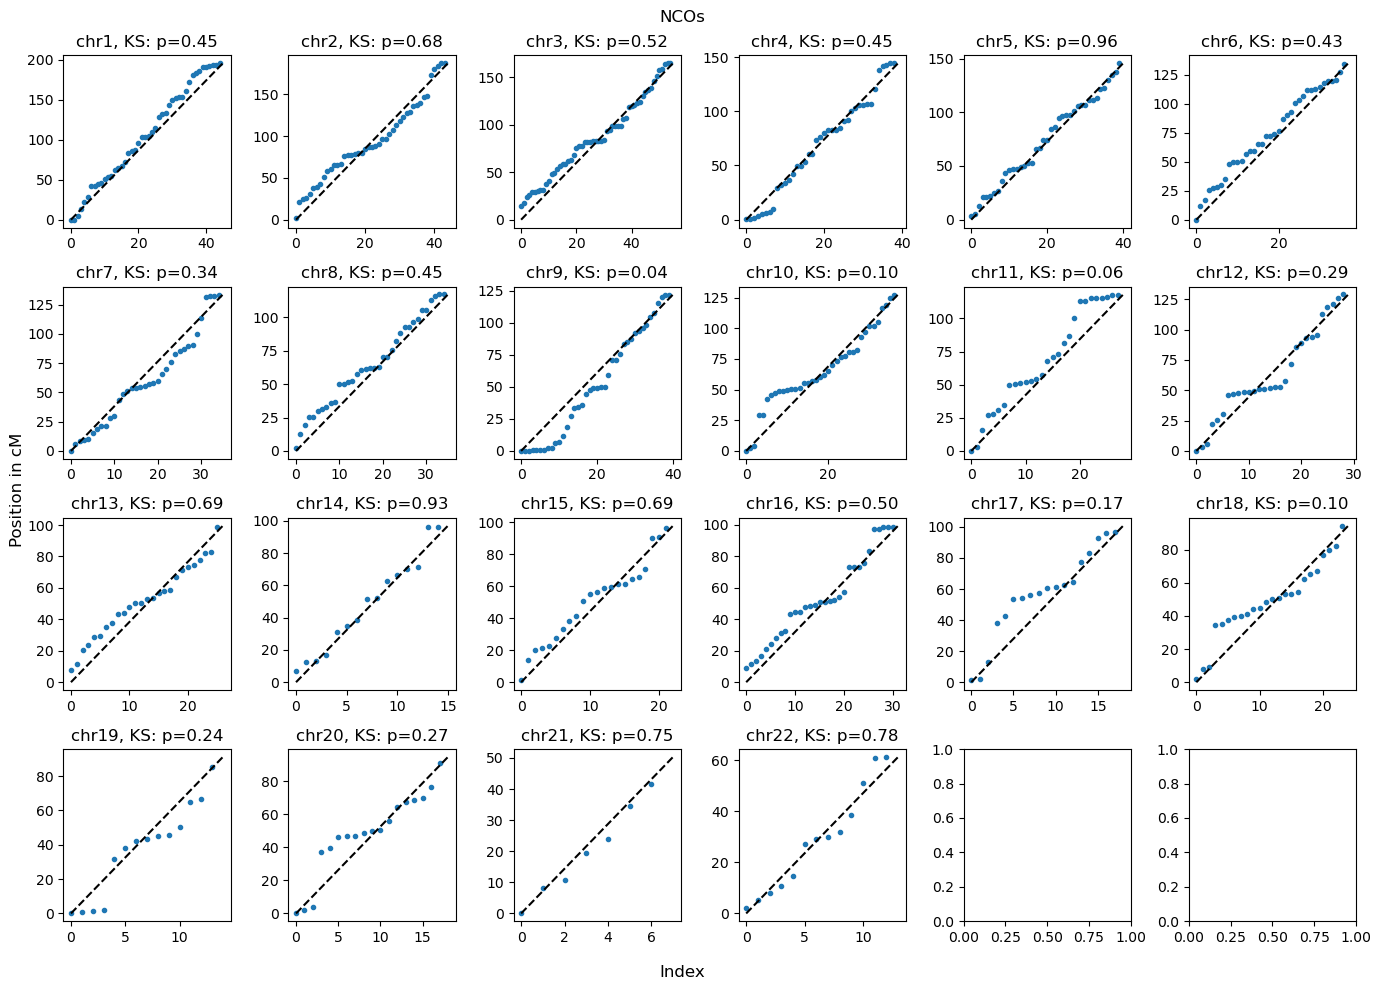

In [45]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    df = (filtered_annotated_candidates_df_expanded
        .filter((pl.col("class") == "GC") & (pl.col("chrom") == chrom))
        .sort("start_pos_cM")
        .drop_nulls()
    )

    midpoints_in_cms = np.sort(df["start_pos_cM"] + df["cM"]/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle("NCOs");
    
plt.tight_layout()

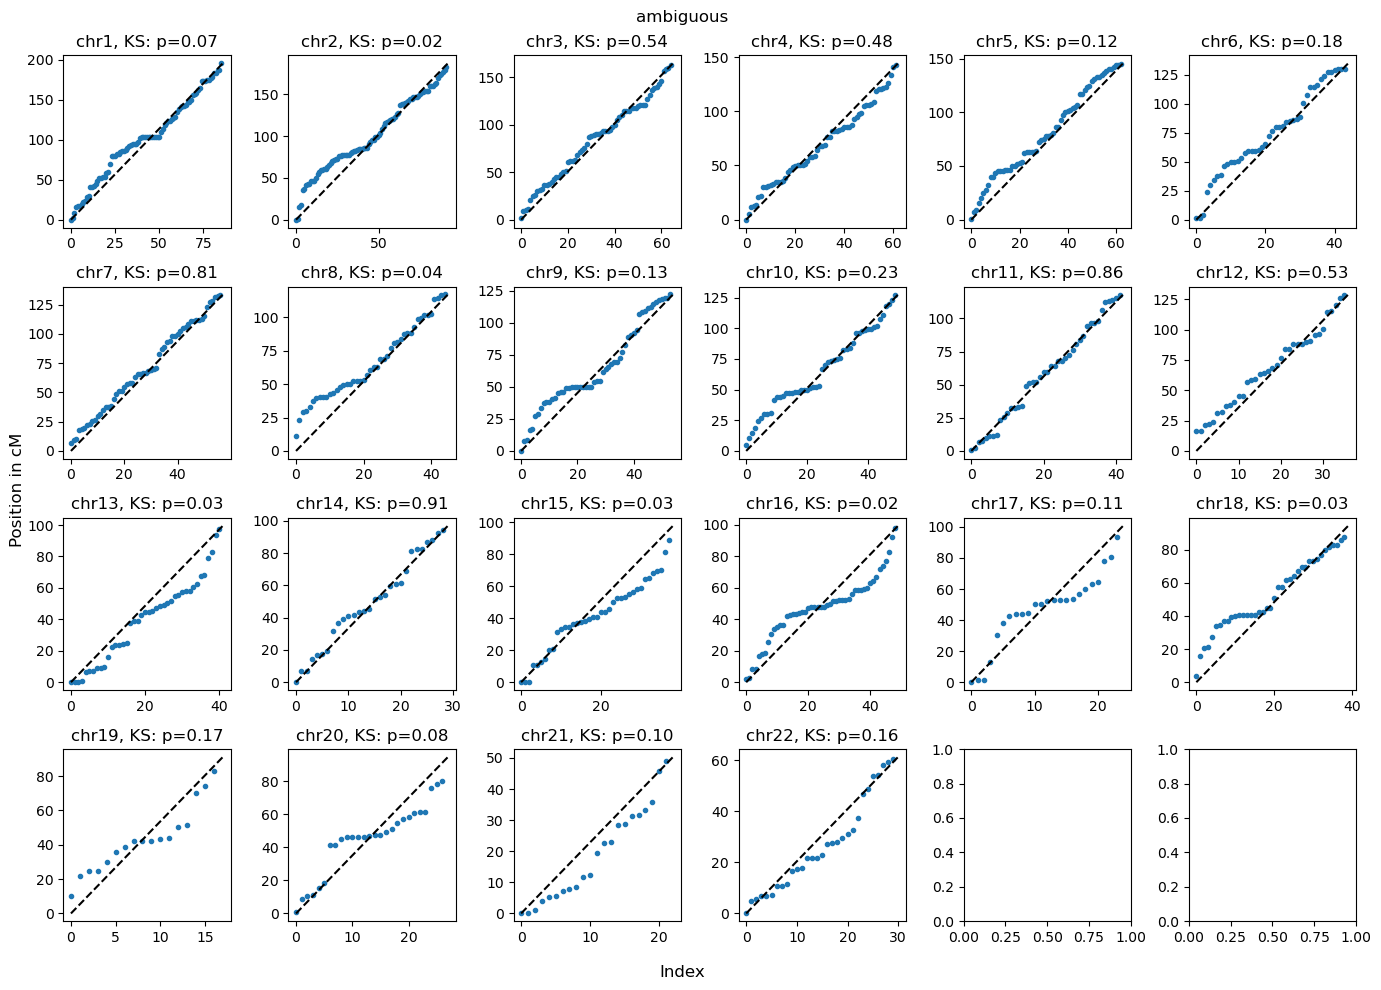

In [46]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    df = (filtered_annotated_candidates_df_expanded
        .filter((pl.col("class") == "ambiguous") & (pl.col("chrom") == chrom))
        .sort("start_pos_cM")
        .drop_nulls()
    )

    midpoints_in_cms = np.sort(df["start_pos_cM"] + df["cM"]/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle("ambiguous");
    
plt.tight_layout()

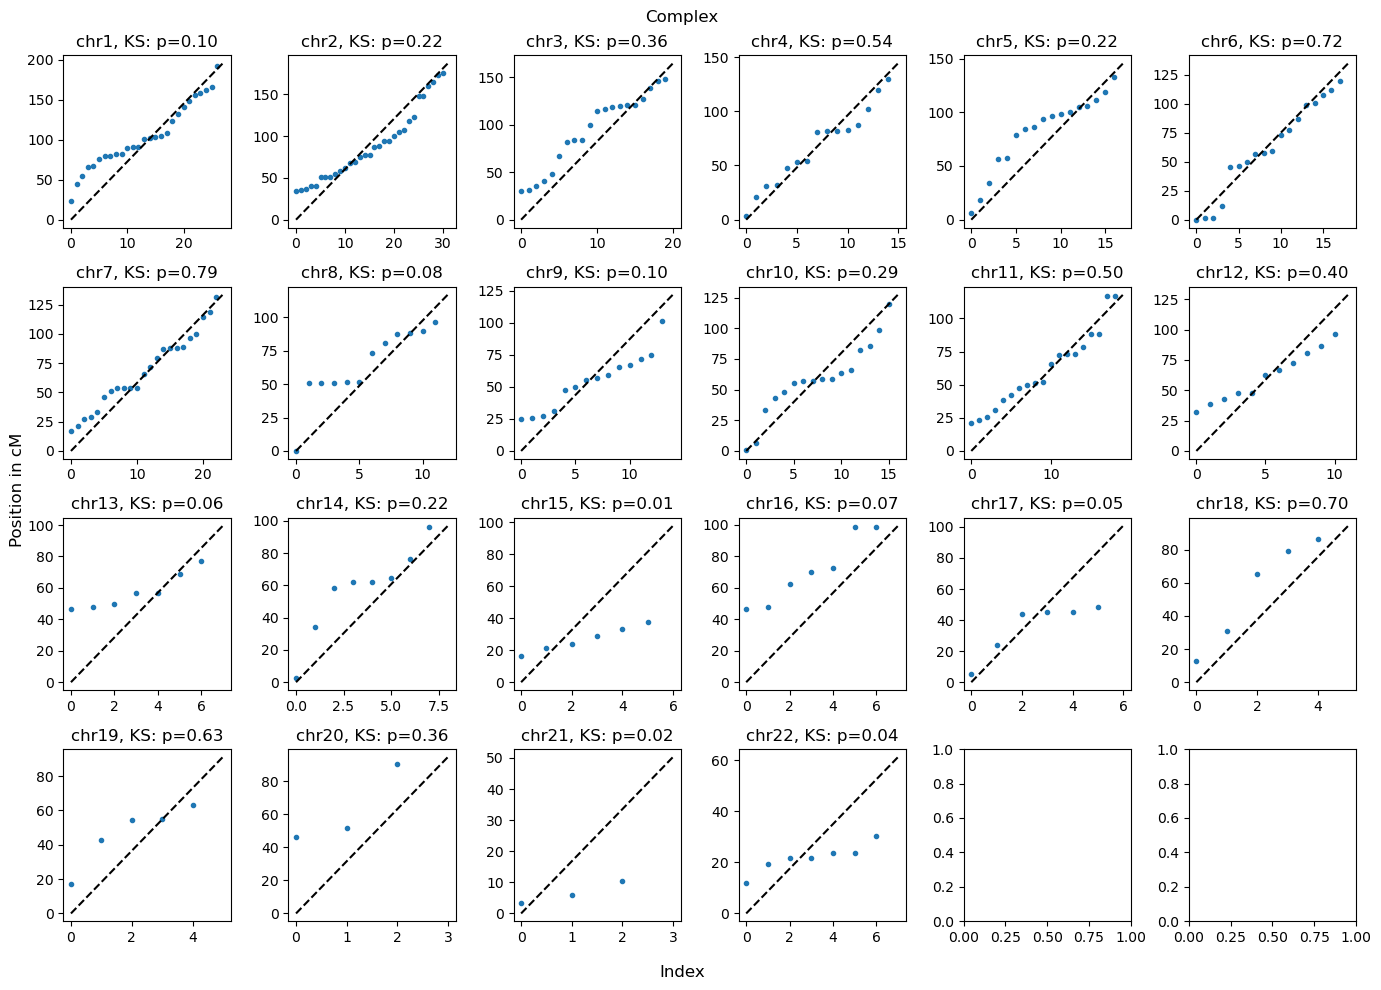

In [47]:
fig, axs = plt.subplots(4, 6, figsize=(14, 10))

for ax, chrom in zip(axs.ravel()[:len(aut_chrom_names)], aut_chrom_names):
    df = (filtered_annotated_candidates_df_expanded
        .filter((pl.col("class") == "CNCO") & (pl.col("chrom") == chrom))
        .sort("start_pos_cM")
        .drop_nulls()
    )

    midpoints_in_cms = np.sort(df["start_pos_cM"] + df["cM"]/2)
    genetic_length_in_cm = annotate.rate_maps[chrom].get_cumulative_mass(annotate.grch37_chromosome_sizes_in_bp[chrom]-1)*1e2
    
    ks_pvalue = scipy.stats.ks_1samp(midpoints_in_cms, scipy.stats.uniform(0, genetic_length_in_cm).cdf).pvalue
    
    ax.plot(midpoints_in_cms, '.')
    ax.plot(
        [0, len(midpoints_in_cms)], 
        [0, genetic_length_in_cm], 
        color="black", 
        ls="--"
    )
    ax.set_title(f"{chrom}, KS: p={ks_pvalue:1.2f}");

fig.supxlabel("Index");
fig.supylabel("Position in cM");
fig.suptitle("Complex");
    
plt.tight_layout()

## Check differences in spatial distribution between classes

In [48]:
cls_maps = {}
for cls in ["CO", "GC", "ambiguous", "CNCO"]:
    cls_maps[cls] = {}
    for chrom in aut_chrom_names:
        cls_maps[cls][chrom] = {}
        
        df = (filtered_annotated_candidates_df_expanded
            .filter((pl.col("class") == cls) & (pl.col("chrom") == chrom))
            .drop_nulls()
        )

        midpoints = np.sort((df["start_pos_0based"] + df["end_pos_0based"])/2)
        
        cls_maps[cls][chrom] = midpoints

        
rows = []
for cls1, cls2 in itertools.combinations(["CO", "GC", "ambiguous", "CNCO"], 2):
    for chrom in aut_chrom_names:
        x,y = cls_maps[cls1][chrom], cls_maps[cls2][chrom]
        if len(x) and len(y):
            pvalue = scipy.stats.ks_2samp(x,y).pvalue
        else:
            pvalue = None
        rows.append([cls1, cls2, chrom, pvalue])
        
cross_classes_df = pl.DataFrame(rows, schema=["class1", "class2", "chrom", "pvalue"])

In [49]:
cross_classes_df.sort("pvalue")

class1,class2,chrom,pvalue
str,str,str,f64
"""CO""","""CNCO""","""chr15""",0.007476
"""GC""","""CNCO""","""chr17""",0.010922
"""CO""","""ambiguous""","""chr15""",0.01333
"""GC""","""CNCO""","""chr15""",0.013569
"""CO""","""GC""","""chr10""",0.016533
…,…,…,…
"""GC""","""CNCO""","""chr20""",0.906015
"""GC""","""ambiguous""","""chr14""",0.924391
"""CO""","""GC""","""chr5""",0.934406


### Combine p-value across chroms

In [50]:
def fishers_method(df):
    k = len(df)
    test_statistic = -2 * np.log(df["pvalue"]).sum()
    pvalue = scipy.stats.chi2(2*k).cdf(test_statistic)
    return pl.DataFrame({
        "class1": df["class1"][0],
        "class2": df["class2"][0],
        "pvalue": pvalue
    })
    
(cross_classes_df
    .group_by("class1", "class2")
    .map_groups(fishers_method)
    .sort("pvalue")
)

class1,class2,pvalue
str,str,f64
"""GC""","""ambiguous""",0.286913
"""GC""","""CNCO""",0.734422
"""CO""","""GC""",0.765018
"""ambiguous""","""CNCO""",0.837739
"""CO""","""CNCO""",0.986203
"""CO""","""ambiguous""",0.999888


## Are there changes in the CO map between individuals?

In [51]:
rows = []

for cls in ["CO", "GC", "ambiguous", "CNCO"]:
    co_maps = {}
    for chrom in aut_chrom_names:
        co_maps[chrom] = {}
        for sample_id in sample_ids:
            df = (filtered_annotated_candidates_df_expanded
                .filter((pl.col("class") == cls) & (pl.col("chrom") == chrom) & (pl.col("sample_id") == sample_id))
                .drop_nulls()
            )

            midpoints = np.sort((df["start_pos_0based"] + df["end_pos_0based"])/2)
            co_maps[chrom][sample_id] = midpoints
    
    for chrom in aut_chrom_names:
        for id1, id2 in itertools.combinations(sample_ids, 2):
            x,y = co_maps[chrom][id1], co_maps[chrom][id2]
            if len(x) and len(y):
                pvalue = scipy.stats.ks_2samp(x,y).pvalue
            else:
                pvalue = None
            rows.append([cls, chrom, id1, id2, pvalue])

cross_samples_df = pl.DataFrame(rows, schema=["class", "chrom", "sample_id1", "sample_id2", "pvalue"]).drop_nulls()

/tmp/ipykernel_13043/4061390000.py:20: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  pvalue = scipy.stats.ks_2samp(x,y).pvalue


In [52]:
cross_samples_df.sort("pvalue")

class,chrom,sample_id1,sample_id2,pvalue
str,str,str,str,f64
"""GC""","""chr3""","""PD50508b""","""PD50489e""",0.002525
"""ambiguous""","""chr12""","""PD50521b""","""PD50489e""",0.002525
"""GC""","""chr2""","""PD50519d""","""PD50489e""",0.003996
"""GC""","""chr2""","""PD50521e""","""PD50489e""",0.007937
"""CO""","""chr5""","""PD50519d""","""PD50521b""",0.012021
…,…,…,…,…
"""CNCO""","""chr22""","""PD50477f""","""PD46180c""",1.0
"""CNCO""","""chr22""","""PD50477f""","""PD50521e""",1.0
"""CNCO""","""chr22""","""PD50519d""","""PD50521b""",1.0


### Combine across chromosomes


In [53]:
def fishers_method(df):
    # k = len(df)
    # test_statistic = -2 * np.log(df["pvalue"]).sum()
    # pvalue = scipy.stats.chi2(2*k).cdf(test_statistic)
    pvalue = scipy.stats.combine_pvalues(df["pvalue"]).pvalue
    return pl.DataFrame({
        "class": df["class"][0],
        "sample_id1": df["sample_id1"][0],
        "sample_id2": df["sample_id2"][0],
        "pvalue": pvalue,
    })
    
cross_samples_agg_df = (cross_samples_df
    .group_by("class", "sample_id1", "sample_id2")
    .map_groups(fishers_method)
    .sort("pvalue")
)

In [54]:
def pvalue_list_to_matrix(df, sample_ids):
    A = np.zeros((len(sample_ids), len(sample_ids)))

    for row in df.iter_rows(named=True):
        i = sample_ids.index(row["sample_id1"])
        j = sample_ids.index(row["sample_id2"])
        A[i,j] = row["corrected_pvalue"]
        
    A += A.T
    outdf = pd.DataFrame(A, index=sample_ids, columns=sample_ids)
    return outdf
                 
                 

In [55]:
df = cross_samples_agg_df.filter(pl.col("class") == "CO")
display(df)


class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""CO""","""PD50519d""","""PD50521b""",0.23521
"""CO""","""PD50508b""","""PD50489e""",0.544761
"""CO""","""PD50523b""","""PD50521b""",0.557283
"""CO""","""PD50477f""","""PD50508b""",0.589979
"""CO""","""PD50477f""","""PD50521b""",0.606058
…,…,…,…
"""CO""","""PD50477f""","""PD50489e""",0.995622
"""CO""","""PD50477f""","""PD50521e""",0.998233
"""CO""","""PD50519d""","""PD50508f""",0.998541


In [56]:
df = cross_samples_agg_df.filter(pl.col("class") == "GC")
display(df)


class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""GC""","""PD50521b""","""PD50489e""",0.514393
"""GC""","""PD50508b""","""PD50489e""",0.551497
"""GC""","""PD50519d""","""PD50508b""",0.69791
"""GC""","""PD50521b""","""PD46180c""",0.810645
"""GC""","""PD50519d""","""PD50489e""",0.862078
…,…,…,…
"""GC""","""PD50477f""","""PD50519d""",0.998712
"""GC""","""PD50521b""","""PD50508b""",0.998896
"""GC""","""PD50477f""","""PD50523b""",0.999269


In [57]:
df = cross_samples_agg_df.filter(pl.col("class") == "ambiguous")
display(df)


class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""ambiguous""","""PD50523b""","""PD46180c""",0.405593
"""ambiguous""","""PD50477f""","""PD46180c""",0.5648
"""ambiguous""","""PD50508f""","""PD46180c""",0.728483
"""ambiguous""","""PD50521b""","""PD50489e""",0.729891
"""ambiguous""","""PD50477f""","""PD50523b""",0.741525
…,…,…,…
"""ambiguous""","""PD50521b""","""PD50521e""",0.999085
"""ambiguous""","""PD50519d""","""PD50521e""",0.999614
"""ambiguous""","""PD50508b""","""PD50489e""",0.999897


In [58]:
df = cross_samples_agg_df.filter(pl.col("class") == "CNCO")
display(df)


class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""CNCO""","""PD50519d""","""PD50508f""",0.653033
"""CNCO""","""PD50519d""","""PD50508b""",0.699537
"""CNCO""","""PD50508f""","""PD46180c""",0.725588
"""CNCO""","""PD50508f""","""PD50521b""",0.746882
"""CNCO""","""PD50477f""","""PD50508b""",0.8
…,…,…,…
"""CNCO""","""PD50477f""","""PD50523b""",1.0
"""CNCO""","""PD50521b""","""PD50508b""",1.0
"""CNCO""","""PD50508b""","""PD46180c""",1.0


### Try again, with permutation testing

In [59]:
def permutation_testing(pairs, n_perms=10, seed=42):
    rng = np.random.default_rng(seed=seed)
    orig = np.sum([scipy.stats.ks_2samp(x, y, method="auto").statistic for x,y in pairs if len(x) and len(y)])
    permuted = []
    for i in range(n_perms):
        sum_stats = 0
        for x,y in pairs:
            if len(x) and len(y):
                z = np.concatenate([x,y])
                px, py = np.split(rng.permutation(z), [len(x)])
                sum_stats += scipy.stats.ks_2samp(px, py, method="auto").statistic
        permuted.append(sum_stats)
        
    pvalue = np.mean(np.array(permuted)>orig)
    return pvalue

In [60]:
import warnings

n_perms = 1000

def runme(cls, co_maps, chrom, sample_id1, sample_id2):
    pairs = [(co_maps[chrom][sample_id1], co_maps[chrom][sample_id2])]
    with warnings.catch_warnings(action="ignore"):
        pvalue = permutation_testing(pairs, n_perms=n_perms)
    return [cls, chrom, sample_id1, sample_id2, pvalue]

rows = []
all_co_maps = {}
for cls in ["CO", "GC", "ambiguous", "CNCO"]:
    print(cls)
    co_maps = {}
    all_co_maps[cls] = co_maps
    for chrom in aut_chrom_names:
        co_maps[chrom] = {}
        for sample_id in sample_ids:
            df = (filtered_annotated_candidates_df_expanded
                .filter((pl.col("class") == cls) & (pl.col("chrom") == chrom) & (pl.col("sample_id") == sample_id))
                .drop_nulls(subset=["start_pos_0based", "end_pos_0based"])
            )

            midpoints = np.sort((df["start_pos_0based"] + df["end_pos_0based"])/2)
            co_maps[chrom][sample_id] = midpoints
    
    cls_rows = joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(runme)(cls, co_maps, chrom, sample_id1, sample_id2) \
            for chrom in aut_chrom_names \
            for sample_id1, sample_id2 in itertools.combinations(sample_ids, 2)
    )
    
    rows.extend(cls_rows)
        

cross_samples_perm_df = pl.DataFrame(rows, schema=["class", "chrom", "sample_id1", "sample_id2", "pvalue"])

CO


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

GC


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:    5.7s
[Paralle

ambiguous


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1508190631866455s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 352 tasks

CNCO


[Parallel(n_jobs=-1)]: Batch computation too fast (0.022969722747802734s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17573308944702148s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s
[

In [61]:
(cross_samples_perm_df
    .filter(pl.col("class") == "CO")
    .sort("pvalue")
)

class,chrom,sample_id1,sample_id2,pvalue
str,str,str,str,f64
"""CO""","""chr13""","""PD50508b""","""PD50489e""",0.0
"""CO""","""chr19""","""PD50508f""","""PD50489e""",0.0
"""CO""","""chr19""","""PD50508b""","""PD50489e""",0.0
"""CO""","""chr19""","""PD46180c""","""PD50489e""",0.0
"""CO""","""chr20""","""PD50519d""","""PD50523b""",0.0
…,…,…,…,…
"""CO""","""chr5""","""PD50477f""","""PD50508f""",0.982
"""CO""","""chr20""","""PD46180c""","""PD50489e""",0.988
"""CO""","""chr6""","""PD50477f""","""PD50523b""",0.99


In [62]:
x = all_co_maps["CO"]["chr19"]['PD50508f']
y = all_co_maps["CO"]["chr19"]["PD50489e"]

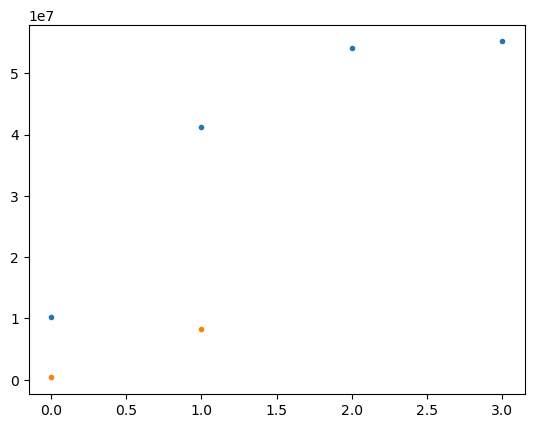

In [63]:
plt.plot(x, '.')
plt.plot(y, '.')

In [64]:
scipy.stats.ks_2samp(x,y).statistic

1.0

In [65]:
px, py = np.split(np.random.permutation(np.concatenate([x,y])), [len(x)])
scipy.stats.ks_2samp(px,py).statistic

0.5

In [66]:
import warnings

n_perms = 1000

def runme(cls, co_maps, sample_id1, sample_id2):
    pairs = [(co_maps[chrom][sample_id1], co_maps[chrom][sample_id2]) for chrom in aut_chrom_names]
    with warnings.catch_warnings(action="ignore"):
        pvalue = permutation_testing(pairs, n_perms=n_perms)
    return [cls, sample_id1, sample_id2, pvalue]

rows = []
for cls in ["CO", "GC", "ambiguous", "CNCO"]:
    print(cls)
    co_maps = {}
    for chrom in aut_chrom_names:
        co_maps[chrom] = {}
        for sample_id in sample_ids:
            df = (filtered_annotated_candidates_df_expanded
                .filter((pl.col("class") == cls) & (pl.col("chrom") == chrom) & (pl.col("sample_id") == sample_id))
                .drop_nulls(subset=["start_pos_0based", "end_pos_0based"])
            )

            midpoints = np.sort((df["start_pos_0based"] + df["end_pos_0based"])/2)
            co_maps[chrom][sample_id] = midpoints
    
    cls_rows = joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(runme)(cls, co_maps, sample_id1, sample_id2) \
            for sample_id1, sample_id2 in itertools.combinations(sample_ids, 2)
    )
    
    rows.extend(cls_rows)
        

cross_samples_perm_agg_df = pl.DataFrame(rows, schema=["class", "sample_id1", "sample_id2", "pvalue"])

CO


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:    9.7s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    9.8s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:   11.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GC


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:    7.7s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    8.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:    9.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ambiguous


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:    8.8s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    9.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:   10.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


CNCO


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1549997329711914s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0398223400115967s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  17 out of  36 | elapsed:    2.7s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed:    3.0s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:    3.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    3.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:    4.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    4.7s finished


In [67]:
(cross_samples_perm_agg_df
    .filter(pl.col("class") == "CNCO")
    .sort("pvalue")
)

class,sample_id1,sample_id2,pvalue
str,str,str,f64
"""CNCO""","""PD50519d""","""PD50508b""",0.0
"""CNCO""","""PD50508f""","""PD50508b""",0.0
"""CNCO""","""PD50523b""","""PD50508b""",0.0
"""CNCO""","""PD50508b""","""PD50521e""",0.0
"""CNCO""","""PD50519d""","""PD50508f""",0.022
…,…,…,…
"""CNCO""","""PD50477f""","""PD50521e""",0.914
"""CNCO""","""PD50519d""","""PD50521b""",0.929
"""CNCO""","""PD50521e""","""PD50489e""",0.951


In [68]:
[all_co_maps["CNCO"][chrom]["PD50519d"] for chrom in aut_chrom_names]

[array([4.86551655e+07, 8.37246270e+07, 1.17041452e+08, 2.29917248e+08,
        2.46528328e+08]),
 array([4.52923805e+07, 8.09125320e+07, 1.25171590e+08, 1.38056682e+08,
        2.38570749e+08, 2.39360552e+08]),
 array([1.58309476e+08]),
 array([2.00306380e+07, 7.12220195e+07, 1.15756818e+08, 1.32652136e+08,
        1.58012416e+08]),
 array([1.19621564e+08, 1.60006600e+08]),
 array([2.91106345e+07, 5.24810905e+07, 1.43748116e+08]),
 array([1.21181575e+07, 1.54565141e+08]),
 array([51834541.5, 56373687.5]),
 array([29517581.5]),
 array([  838688.5,  2608521. , 19739190.5, 63955992. , 69336681.5]),
 array([2.34158045e+07, 3.61349950e+07, 8.61945840e+07, 1.03432210e+08,
        1.23798891e+08, 1.34641054e+08]),
 array([10895260. , 22393235.5, 41923821. , 42070353. , 84673163. ]),
 array([], dtype=float64),
 array([86072390.5]),
 array([], dtype=float64),
 array([79285649.]),
 array([15370035.5, 32986315.5]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([33585167.5, 4544290

# Compare # seq errors vs. rate map

In [69]:
testme = (filtered_annotated_candidates_df_expanded
    .select(
        "read_name", 
        "total_mismatches", 
        "total_common_insertions",
        "num_common_insertions",
        "num_common_deletions",
        "total_clipping",
        "read_length",
        "cM",
    )
    .unique()
    .drop_nulls()
    .with_columns(
        normalized_total_mismatches = pl.col("total_mismatches") / pl.col("read_length")
    )          
)

In [70]:
scipy.stats.pearsonr(testme["total_mismatches"], np.log10(testme["cM"]+1e-8))

PearsonRResult(statistic=-0.22184272121596116, pvalue=1.3626062999990083e-42)

In [71]:
qs = np.quantile(testme["cM"], np.linspace(0,1,11))
for q in qs[:-1]:
    print(
        q, 
        testme.filter(pl.col("cM")<= q)["total_mismatches"].mean(),
        testme.filter(pl.col("cM")> q)["total_mismatches"].mean(),
        scipy.stats.ttest_ind(
            testme.filter(pl.col("cM")<= q)["total_mismatches"],
            testme.filter(pl.col("cM")> q)["total_mismatches"]
        ).pvalue
    )

0.0 2.5 3.382702702702703 0.7756444835683376
0.00046146212050288685 9.7088948787062 2.6771488469601676 2.524669098716842e-40
0.002353791896986479 7.45822102425876 2.3608490566037736 9.972741299714163e-38
0.009641671201225678 6.32973944294699 2.11628802464382 6.192921824150086e-34
0.02198924409480356 5.626010781671159 1.8831985624438454 1.0374658657949513e-30
0.04329033329300058 4.988679245283019 1.7719676549865229 6.4699971435930984e-24
0.07124788766759887 4.462713387241689 1.7567385444743935 1.0990822960352637e-16
0.10989310469095843 4.065075086638429 1.7825696316262354 6.473987597538197e-11
0.1706237501130034 3.7951482479784366 1.721024258760108 2.269122171049596e-07
0.3178597315915361 3.525007487271638 2.078167115902965 0.006844649001800336


In [72]:
qs

array([0.00000000e+00, 4.61462121e-04, 2.35379190e-03, 9.64167120e-03,
       2.19892441e-02, 4.32903333e-02, 7.12478877e-02, 1.09893105e-01,
       1.70623750e-01, 3.17859732e-01, 1.57817288e+00])

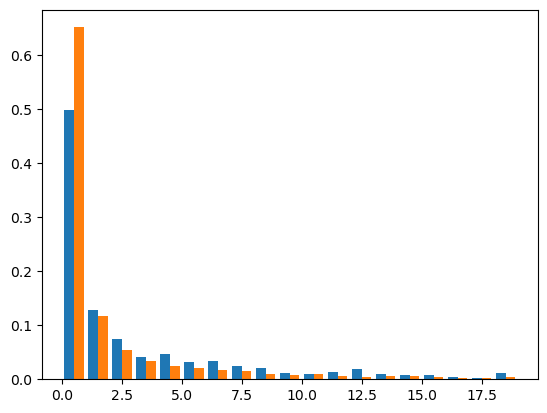

In [73]:
q = qs[2]

plt.hist(
    [
        testme.filter(pl.col("cM")<= q)["total_mismatches"],
        testme.filter(pl.col("cM")> q)["total_mismatches"]
    ],
    bins=np.arange(20),
    log=False,
    density=True,
);
        

## Test cM in random reads

In [74]:
%%time

def runme(focal_sample_id, chrom):
    df = (
        pl.scan_parquet(
            Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.high_confidence_snps.parquet"
        )
        .select(["read_name", 'total_mismatches', 'total_common_insertions', 'num_common_insertions', 'num_common_deletions', 'total_clipping', "read_length1"])
        .unique()
        .collect(streaming=True)
    )
    return df
        
errors_df = pl.concat(
    joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(runme)(focal_sample_id, chrom) 
            for focal_sample_id in sample_ids for chrom in aut_chrom_names
    )
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:  1

CPU times: user 5.42 s, sys: 5.17 s, total: 10.6 s
Wall time: 1min 28s


In [75]:
errors_df

read_name,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,read_length1
str,i64,i64,u32,u32,i64,i32
"""m64094e_220917…",3,23,23,26,114,9758
"""m64230e_220906…",0,0,0,0,0,15119
"""m64230e_220906…",20,194,167,21,0,18105
"""m64230e_220906…",1,9,2,2,0,14332
"""m64178e_220829…",0,0,0,2,0,10617
…,…,…,…,…,…,…
"""m64094e_220717…",1,3,1,0,0,14895
"""m64174e_220620…",2,8,7,21,163,18224
"""m64094e_220715…",0,0,0,2,0,8467


In [76]:
testme_random = (all_annotated_random_df
    .filter(
        (pl.col("mapq") >= 60) & 
        (pl.col("is_forward1") == pl.col("is_forward2")) & 
        (pl.col("total_clipping") <= 10) &
        (pl.col("total_mismatches") <= 100)
    )
    .join(errors_df, on="read_name")
    .with_columns(
        normalized_total_mismatches = pl.col("total_mismatches") / pl.col("read_length1")
    )
)

In [77]:
print(testme_random["total_mismatches"].mean())
print(testme_random.filter(pl.col("cM_per_bp_across_read") > 5e-6)["total_mismatches"].mean())


1.5920809245363239
1.7972157320872275


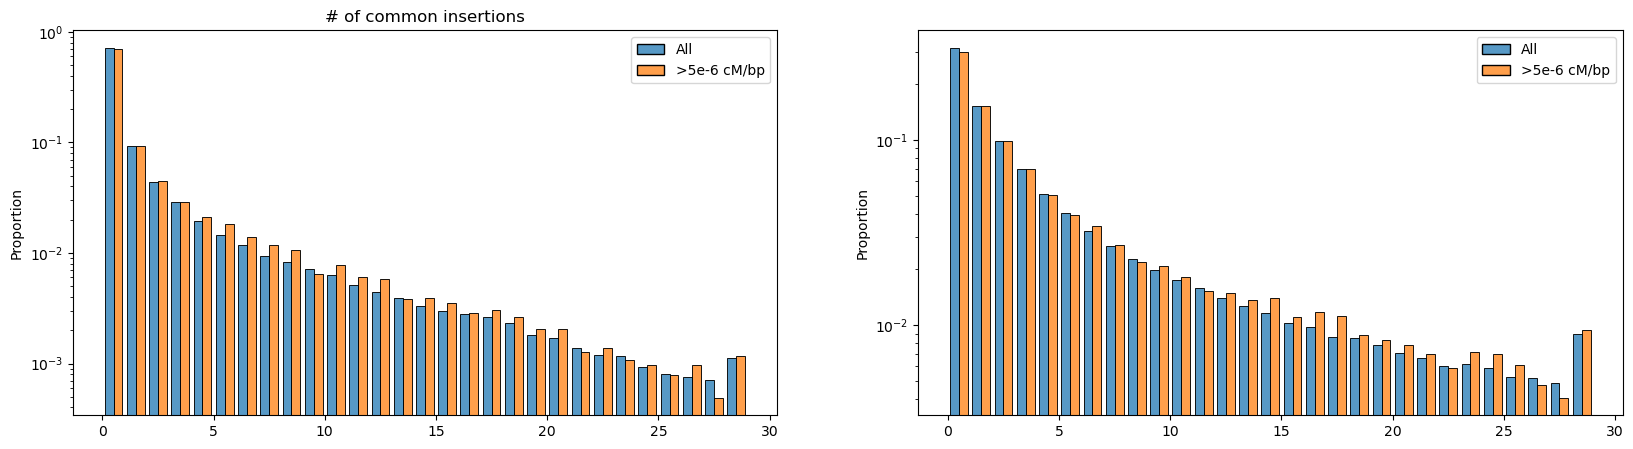

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(
    [
        pd.Series(testme_random["total_mismatches"], name="All"),
        pd.Series(testme_random.filter(pl.col("cM_per_bp_across_read") > 5e-6)["total_mismatches"], name=">5e-6 cM/bp"),
    ], 
    bins=np.arange(0, 30),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=axs[0],
)

axs[0].set_yscale("log");
axs[0].set_title("# of common mismatches");
#plt.ylim(0,0.05);

sns.histplot(
    [
        pd.Series(testme_random["total_common_insertions"], name="All"),
        pd.Series(testme_random.filter(pl.col("cM_per_bp_across_read") > 5e-6)["total_common_insertions"], name=">5e-6 cM/bp"),
    ], 
    bins=np.arange(0, 30),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=axs[1],
)

axs[1].set_yscale("log");
axs[0].set_title("# of common insertions");
#plt.ylim(0,0.05);



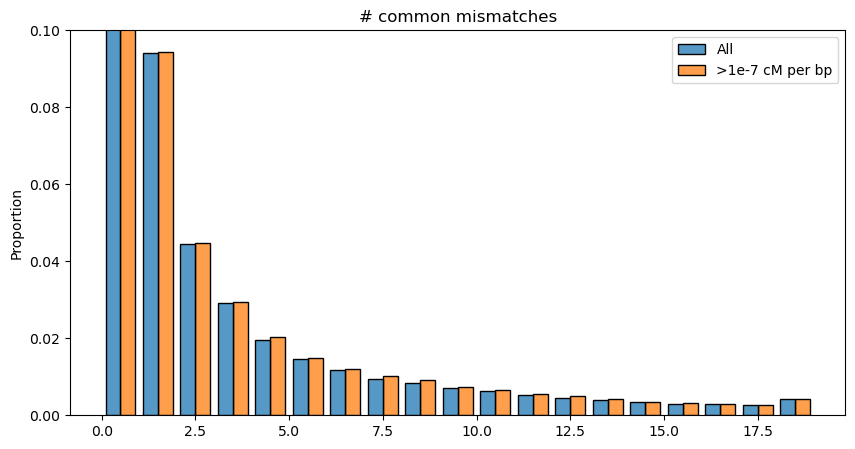

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    [
        pd.Series(testme_random["total_mismatches"], name="All"),
        pd.Series(testme_random.filter(pl.col("cM_per_bp_across_read") > 1e-7)["total_mismatches"], name=">1e-7 cM per bp"),
    ], 
    bins=np.arange(20),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#ax.set_yscale("log");
ax.set_title("# common mismatches");
ax.set_ylim(0,0.1);


In [80]:
filtered_annotated_candidates_df_expanded

read_name,frac_fits1_super_conf,start_pos_0based,end_pos_0based,mapq,read_length,start_pos_cM,cM,prob_CO,cM_per_bp_across_read,sample_id,chrom,read_length_right,n_transitions,idx_transitions,snp_positions_on_read,class,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,min_coverage_between_transitions_hap1,min_coverage_between_transitions_hap2,mapq1,mapq2,is_forward1,is_forward2,has_common_transition,chrom_denovo,active_start_pos,active_end_pos,active_region_length,active_start_pos_cM,active_end_pos_cM,active_cM,cM_per_bp_across_active
str,f64,i64,i64,i64,i64,f64,f64,f64,f64,str,str,i64,i64,list[i64],list[i64],str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,bool,bool,bool,str,i64,i64,i64,f64,f64,f64,f64
"""m64178e_220829…",0.5,7161301,7174900,60,13569,16.921781,0.112327,0.001123,0.000008,"""PD50477f""","""chr1""",13569,1,[3],"[3191, 4854, … 8953]","""CO""",1,3,3,18,0,0,12,12,60,60,false,false,false,"""chr1_RagTag""",7168178,7169711,1533,16.922872,16.923238,0.000365,2.3841e-7
"""m64178e_220829…",0.090909,237411858,237424656,60,12813,172.056966,0.091351,0.000913,0.000007,"""PD50477f""","""chr1""",12813,2,"[9, 10]","[572, 1165, … 12016]","""GC""",0,12,9,2,0,0,12,11,60,60,false,false,false,"""chr1_RagTag""",237419337,237419587,250,172.102234,172.105654,0.00342,0.000014
"""m64094e_220917…",0.5,172423722,172436100,60,12360,126.087207,0.000414,0.000004,3.3502e-8,"""PD50477f""","""chr1""",12360,1,[0],"[2484, 9706]","""ambiguous""",0,2,1,1,0,0,7,7,60,60,false,false,false,"""chr1_RagTag""",172426206,172433428,7222,126.087381,126.087564,0.000182,2.5255e-8
"""m64094e_220917…",0.5,29570226,29587508,60,17423,41.654386,0.01302,0.00013,7.4728e-7,"""PD50477f""","""chr1""",17423,1,[0],"[8002, 14134]","""ambiguous""",28,171,151,29,0,0,7,3,60,60,true,true,false,"""chr1_RagTag""",29578228,29584360,6132,41.654615,41.666104,0.011489,0.000002
"""m64230e_220906…",0.333333,72273680,72289319,60,15640,74.583235,0.056852,0.000568,0.000004,"""PD50477f""","""chr1""",15640,1,[1],"[1672, 7742, … 14127]","""CO""",0,1,1,0,0,0,12,9,60,60,false,false,false,"""chr1_RagTag""",72281422,72282482,1060,74.614764,74.619548,0.004784,0.000005
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""m64094e_220717…",0.5,22734850,22743204,60,8345,8.957057,0.013804,0.000138,0.000002,"""PD50489e""","""chr22""",8345,1,[2],"[4835, 5037, … 5449]","""CO""",0,0,0,12,0,0,11,6,60,60,false,false,false,"""chr22_RagTag""",22739946,22740269,323,8.963455,8.963861,0.000406,0.000001
"""m64094e_220717…",0.666667,43744463,43753034,60,8607,35.097309,0.019734,0.000197,0.000002,"""PD50489e""","""chr22""",8607,1,[6],"[566, 625, … 6243]","""CO""",0,7,4,7,0,0,8,7,60,60,true,true,false,"""chr22_RagTag""",43746853,43747649,796,35.103013,35.105662,0.002649,0.000003
"""m64094e_220715…",0.25,null,null,null,null,null,null,null,null,"""PD50489e""","""chr22""",14367,2,"[4, 6]","[1089, 6349, … 10948]","""GC""",4,34,34,18,0,0,10,11,60,60,true,true,false,"""chr22_RagTag""",null,null,null,NaN,NaN,NaN,null


## Compare random reads to candidate reads

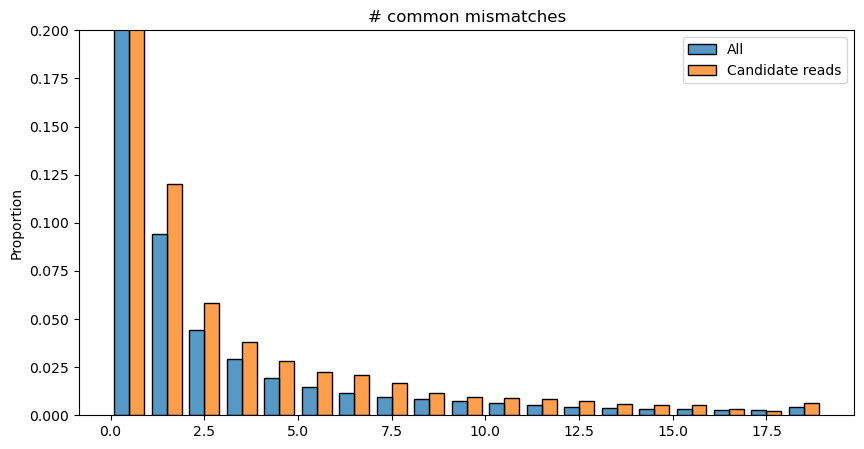

In [81]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    [
        pd.Series(testme_random["total_mismatches"], name="All"),
        pd.Series(filtered_annotated_candidates_df_expanded["total_mismatches"], name="Candidate reads"),
    ], 
    bins=np.arange(20),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#ax.set_yscale("log");
ax.set_title("# common mismatches");
ax.set_ylim(0,0.2);


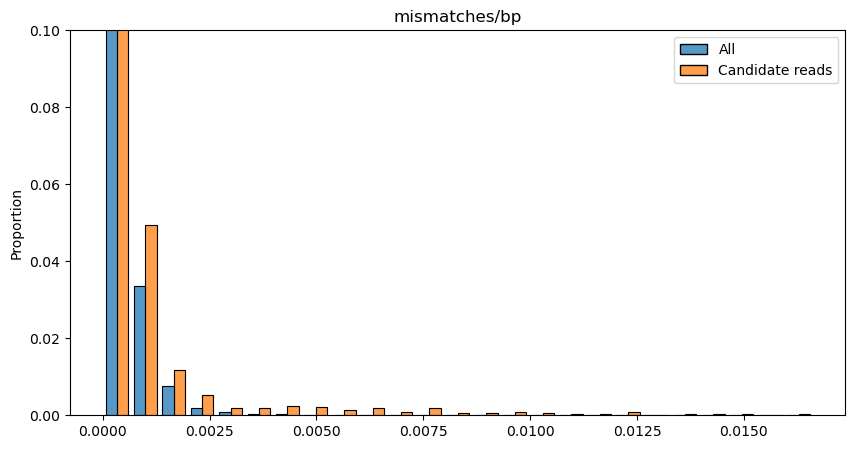

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    [
        pd.Series(testme_random["normalized_total_mismatches"], name="All"),
        pd.Series(
            filtered_annotated_candidates_df_expanded["total_mismatches"] / filtered_annotated_candidates_df_expanded["read_length"], 
            name="Candidate reads"
        ),
    ], 
    bins=25,
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#ax.set_yscale("log");
ax.set_title("mismatches/bp");
ax.set_ylim(0,0.1);
